In [2]:
# Import packages
import numpy as np
import pandas as pd
import math
import sklearn
import sklearn.preprocessing
import datetime
import os
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error

import warnings
warnings.simplefilter(action='ignore', category=Warning)
import seaborn as sns
sns.set()
pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
#Program that executes the rolling window train-val-test split 
%run TimeBasedCV.ipynb

In [4]:
#Read in the cleansed and winsorised data
df = pd.read_csv('cleaned.csv', parse_dates =["eom"])
df.drop('date', axis=1, inplace=True)
df['eom'] = pd.to_datetime(df['eom'])
#Convert to float 32 (format needed for the most ML models)
cols_to_front = ['permno', 'eom', 'ret_excess']
df = df[cols_to_front + [c for c in df.columns if c not in cols_to_front]]
df[df.columns[3:]] = df[df.columns[3:]].astype('float32')
#Sort observations by date and stock id
df = df.sort_values(by = ['eom', 'permno'], ascending = True)
df.head()

,permno,eom,ret_excess,mvel1,beta,betasq,chmom,dolvol,idiovol,indmom,...,securedind,sin,baspread,ill,maxret,retvol,std_dolvol,std_turn,zerotrade,sic2
0,10006,1959-07-31,0.064813,71077.250,1.186630,1.408090,-0.189153,9.754356,0.025758,0.434433,...,0.0,0.0,0.013859,1.956238e-07,0.020151,0.013405,0.474575,0.513313,1.056137e-07,37.0
1,10014,1959-07-31,-0.000025,9723.375,1.687401,2.847321,0.112981,8.221681,0.069418,0.434433,...,0.0,0.0,0.037710,2.040267e-06,0.100000,0.036694,0.520349,0.916624,6.106661e-08,35.0
2,10022,1959-07-31,-0.008954,21210.000,1.022527,1.045561,0.146052,8.734319,0.041049,0.434433,...,0.0,0.0,0.026405,8.405795e-07,0.052083,0.025663,1.192576,4.492107,2.310417e-08,35.0
3,10030,1959-07-31,0.105999,83415.000,1.232348,1.518681,-0.038157,9.981096,0.023733,0.434433,...,0.0,0.0,0.016875,6.822973e-07,0.029557,0.016014,1.192576,1.285815,9.657306e-08,35.0
4,10057,1959-07-31,-0.016352,30625.000,1.209462,1.462798,0.088590,8.784775,0.030906,0.434433,...,0.0,0.0,0.008054,3.425895e-07,0.055319,0.014424,1.009791,1.615000,1.909091e+00,35.0


### Rank standardization  in inreval [-1,1]

A rank standardization procedure following Kelly, Pruitt, and Su (2019) and Freyberger, Neuhierl, and Weber (2020) is employed. The stock characteristics are ranked month-by-month cross-sectionally and the ranks are mapped into the [-1,1] interval, thereby transforming features into a uniform distribution and increasing the insensitivity to outliers

In [5]:
#Standardize all independent variables
features = df.columns[~df.columns.isin(["eom",'permno',"ret_excess"])].tolist()

#Ranks in [0,1]interval
df[features]=df.groupby("eom")[features].rank(pct=True)

#Multiply by 2 and substract 1 to get ranks in interval [-1,1] 
df[features] = 2*df[features] - 1

In [6]:
df["permno2"] = df["permno"].copy()
df["eom2"] = df["eom"].copy()
df = df.set_index(['eom2','permno2'])
df.head()

permno        eom  ret_excess     mvel1      beta  \
eom2       permno2                                                      
1959-07-31 10006     10006 1959-07-31    0.064813  0.043802  0.308481   
           10014     10014 1959-07-31   -0.000025 -0.830382  0.817335   
           10022     10022 1959-07-31   -0.008954 -0.561976  0.075489   
           10030     10030 1959-07-31    0.105999  0.118360  0.375582   
           10057     10057 1959-07-31   -0.016352 -0.392358  0.347623   

                      betasq     chmom    dolvol   idiovol    indmom  ...  \
eom2       permno2                                                    ...   
1959-07-31 10006    0.308481 -0.215284  0.258155 -0.371855  0.000932  ...   
           10014    0.817335  0.774464 -0.573159  0.977633  0.000932  ...   
           10022    0.075489  0.822926 -0.325256  0.632805  0.000932  ...   
           10030    0.375582  0.405405  0.394222 -0.524697  0.000932  ...   
           10057    0.347623  0.731594 -0.302889  0.120224  0.000932  ...   

                    securedind       sin  baspread       ill    maxret  \
eom2       permno2                                                       
1959-07-31 10006      0.000932  0.000932 -0.204101 -0.295433 -0.638397   
           10014      0.000932  0.000932  0.951538  0.785648  0.944082   
           10022      0.000932  0.000932  0.759553  0.461323  0.587139   
           10030      0.000932  0.000932  0.148183  0.347623 -0.152842   
           10057      0.000932  0.000932 -0.800559 -0.002796  0.658900   

                      retvol  std_dolvol  std_turn  zerotrade      sic2  
eom2       permno2                                                       
1959-07-31 10006   -0.282386   -0.658900  0.168686  -0.356943  0.616962  
           10014    0.953402   -0.500466  0.524697  -0.647717 -0.024231  
           10022    0.783784    0.990680  0.972041  -0.947810 -0.024231  
           10030    0.062442    0.990680  0.699907  -0.397950 -0.024231  
           10057   -0.155638    0.908667  0.789376   0.639329 -0.024231  

[5 rows x 31 columns]

# Gradient boosted regression trees

### Tuning parameters:

- shrinkage/learning weight **𝜈**: **learning_rate**
- debth of the simple trees **𝐿**: **max_depth**
- the number of trees **𝐵** added to the ensemble model: **n_estimators** 

## All firms

In [7]:
#Define huber loss function to minimize in the validation step
def huber_loss_error(y_true, y_pred, delta=1.35):
    res = []
    for i in zip(y_true, y_pred):
        if abs(i[0]-i[1])<=delta:
            res.append(0.5*((i[0]-i[1])**2))
        else:
            res.append(delta*((abs(i[0]-i[1]) )-0.5*(delta**2)))
    return np.sum(res)

In [9]:
import time
import warnings
warnings.filterwarnings('ignore')

tscv = TimeBasedCV(train_period=60,
                   val_period=24,
                   test_period=12,
                   freq='months')

#Define the idependent variables (X) and the dependent variable (y)
features = df.columns[~df.columns.isin(['eom', 'permno',"ret_excess"])].tolist()
X = df[features]
y = df["ret_excess"]
#Empty containers to save results from each window
predictions = []
y_test_list =[]
dates = []
dic_r2_all = {}
# Model’s complexity: dictionary to save the number of predictors randomly considered as potential split variables over time
dic_max_depth_all = {}


# track progress
print("Starting rolling window training...")
window_count = 0
start_total_time = time.time()

for train_index, val_index, test_index in tscv.split(df, 
                                                    first_split_date=datetime.date(1965,12,31), 
                                                    second_split_date=datetime.date(2020,1,31), 
                                                    date_column="eom"):
    window_count += 1
    window_start = time.time()
    
    print(f"\n{'='*50}")
    print(f"Processing window {window_count}")
    print(f"{'='*50}")
    
    X_train = X.loc[train_index]
    y_train = y.loc[train_index]
    X_val = X.loc[val_index]
    y_val = y.loc[val_index]
    X_test = X.loc[test_index]
    y_test = y.loc[test_index]
    
    print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")
    
    # simplify
    param_grid = {
        'max_depth': [3, 4, 5],
        'n_estimators': [100],
        "learning_rate": [0.1],
        "max_features": ["sqrt"],
        "min_samples_split": [5000, 8000],
        "min_samples_leaf": [100, 200]
    }
    
    grid = list(ParameterGrid(param_grid))
    print(f"Testing {len(grid)} hyperparameter combinations...")
    
    best_loss = float('inf')
    best_params = None
    
    for i, params in enumerate(grid):
        try:
            GBR_val = GradientBoostingRegressor(
                loss='huber',
                max_depth=params["max_depth"],
                learning_rate=params["learning_rate"],
                n_estimators=params["n_estimators"],
                max_features=params["max_features"],
                min_samples_split=params["min_samples_split"],
                min_samples_leaf=params["min_samples_leaf"],
                random_state=42
            )
            
            GBR_val.fit(X_train, y_train)
            Yval_predict = GBR_val.predict(X_val)
            loss = huber_loss_error(y_val, Yval_predict, delta=1.35)
            
            if loss < best_loss:
                best_loss = loss
                best_params = params
                
        except Exception as e:
            print(f"Warning: Failed with params {params}: {e}")
            continue
    
    if best_params is None:
        print(f"Warning: No valid model found for window {window_count}, skipping...")
        continue
    
    GBR = GradientBoostingRegressor(
        loss='huber',
        max_depth=best_params["max_depth"],
        learning_rate=best_params["learning_rate"],
        n_estimators=best_params["n_estimators"],
        max_features=best_params["max_features"],
        min_samples_split=best_params["min_samples_split"],
        min_samples_leaf=best_params["min_samples_leaf"],
        random_state=42
    )
    
    X_train_val = pd.concat([X_train, X_val])
    y_train_val = pd.concat([y_train, y_val])
    
    print(f"Training final model with max_depth={best_params['max_depth']}...")
    GBR.fit(X_train_val, y_train_val)
    preds = GBR.predict(X_test)
    
    # save results
    predictions.append(preds)
    dates.append(y_test.index)
    y_test_list.append(y_test)
    
    r2 = 1 - sum(pow(y_test - preds, 2)) / sum(pow(y_test, 2))
    dic_r2_all["r2." + str(y_test.index)] = r2
    dic_max_depth_all["feat." + str(y_test.index)] = best_params["max_depth"]
    
    window_time = time.time() - window_start
    print(f"Window {window_count} completed in {window_time:.2f} seconds, R2: {r2:.4f}")

if predictions: 
    predictions_all = np.concatenate(predictions, axis=0)
    y_test_list_all = np.concatenate(y_test_list, axis=0)
    
    R2OOS_GBR = 1 - sum(pow(y_test_list_all - predictions_all, 2)) / sum(pow(y_test_list_all, 2))
    
    total_time = time.time() - start_total_time
    print(f"\n{'='*50}")
    print(f"Training completed!")
    print(f"Total time: {total_time:.2f} seconds")
    print(f"Number of windows processed: {window_count}")
    print(f"R2OOS gradient boosted regression tree: {R2OOS_GBR:.6f}")
    print(f"{'='*50}")
else:
    print("Warning: No predictions were generated!")

Starting rolling window training...
Train period: 1960-12-31 - 1965-12-31 ,val period: 1965-12-31 - 1967-12-31 , Test period 1967-12-31 - 1968-12-31 # train records 70919 ,# val records 41209 , # test records 13008
Train period: 1961-12-31 - 1966-12-31 ,val period: 1966-12-31 - 1968-12-31 , Test period 1968-12-31 - 1969-12-31 # train records 83549 ,# val records 32603 , # test records 17740
Train period: 1962-12-31 - 1967-12-31 ,val period: 1967-12-31 - 1969-12-31 , Test period 1969-12-31 - 1970-12-31 # train records 91319 ,# val records 30748 , # test records 18674
Train period: 1963-12-31 - 1968-12-31 ,val period: 1968-12-31 - 1970-12-31 , Test period 1970-12-31 - 1971-12-31 # train records 87957 ,# val records 36414 , # test records 16997
Train period: 1964-12-31 - 1969-12-31 ,val period: 1969-12-31 - 1971-12-31 , Test period 1971-12-31 - 1972-12-31 # train records 86909 ,# val records 35671 , # test records 23194
Train period: 1965-12-31 - 1970-12-31 ,val period: 1970-12-31 - 1972-

In [10]:
pd.DataFrame(dic_max_depth_all.items())
max_depth =pd.DataFrame(dic_max_depth_all.items(), columns=['Identifier', 'max_depth'])

In [12]:
yhat = predictions_all.tolist()
y_true = y_test_list_all.tolist()
dates_all= np.concatenate(dates, axis=0)
i = dates_all.tolist()

results = pd.DataFrame(
    {'identifier': i,
     'yhat': yhat,
     'y_true': y_true
    })

In [13]:
results.head()

,identifier,yhat,y_true
0,"(1968-01-31 00:00:00, 10006)",0.013047,-0.041823
1,"(1968-01-31 00:00:00, 10014)",0.016336,0.087460
2,"(1968-01-31 00:00:00, 10030)",0.011766,0.034743
3,"(1968-01-31 00:00:00, 10057)",0.027811,0.017201
4,"(1968-01-31 00:00:00, 10065)",-0.018461,-0.011992


,max_depth,time
0,5,968-01-31'
1,5,968-12-31'
2,5,969-12-31'
3,4,970-12-31'
4,3,971-12-31'
5,3,973-01-31'
6,3,973-12-31'
7,5,974-12-31'
8,3,975-12-31'
9,5,976-12-31'


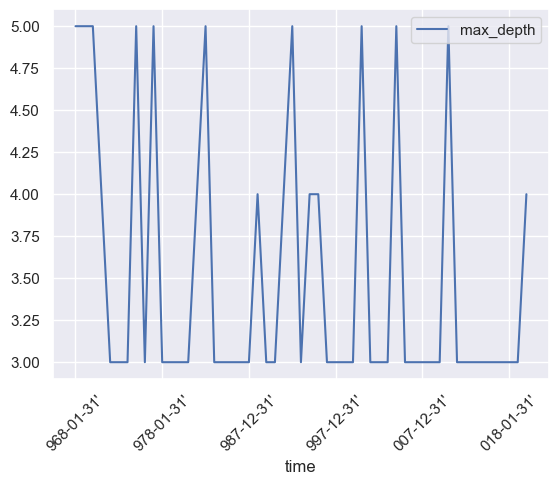

In [14]:
# Convert dictionary containing the Number of predictors randomly considered as potential split variables over time in dataframe
pd.DataFrame(dic_max_depth_all.items())
max_depth =pd.DataFrame(dic_max_depth_all.items(), columns=['Identifier', 'max_depth'])
max_depth['Identifier'] = max_depth['Identifier'].astype(str)
max_depth["time"] = max_depth["Identifier"].str[20:30]
max_depth.drop(["Identifier"], axis = 1, inplace = True)

# #Plot time-varying model complexity
max_depth.set_index('time').plot()
plt.xticks(rotation=45)
max_depth

In [15]:
results['date'] = results['identifier'].str[0]
results['id'] = results['identifier'].str[1]
results.drop(["identifier"],axis = 1, inplace=True)
results['date'] = pd.to_datetime(results['date'], format='%Y-%m-%d')
results['MonthYear'] = results['date'].dt.to_period('M')
results = results.sort_values(by = ['date', 'id'], ascending = True)
results = results.set_index(['MonthYear','id'])
results

yhat    y_true       date
MonthYear id                                  
1968-01   10006  0.013047 -0.041823 1968-01-31
          10014  0.016336  0.087460 1968-01-31
          10030  0.011766  0.034743 1968-01-31
          10057  0.027811  0.017201 1968-01-31
          10065 -0.018461 -0.011992 1968-01-31
...                   ...       ...        ...
2020-11   93423 -0.047093  0.421368 2020-11-30
          93426 -0.029541  0.224361 2020-11-30
          93427 -0.025179  0.138120 2020-11-30
          93434 -0.042082  0.144736 2020-11-30
          93436 -0.045163  0.462735 2020-11-30

[2666935 rows x 3 columns]

### Time-varying model complexity

In [16]:
# Save results to use for Diebold-Mariano test
gbrt= results.reset_index()
gbrt.to_csv('gbrt.csv', index = False)